# Sentiment Classification with Transformer (Self-Study)

In this unit, we implement a transformer-based Sentiment Classifier for the NLTK movie reviews dataset.

## Dependencies

In [1]:
import nltk, random
import numpy as np
from nltk.corpus import movie_reviews
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from lime.lime_text import LimeTextExplainer

In [2]:
## checking tf version
print(tf.__version__)

2.13.0


## Transformer Block

- A Transformer block consists of layers of Self Attention, Normalization, and feed-forward networks (i.e., MLP or Dense)).
- We use the `TransformerBlock` provided by `keras` (See keras official tutorial on [Text Classification with Transformer](https://keras.io/examples/nlp/text_classification_with_transformer/).
![](../images/transformer-block.svg)
(<small>Source: [Transformers From Scratch](http://peterbloem.nl/blog/transformers)<small>)

In [3]:
# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

## Embedding and Position

- And in Transformer-based networks, we need to include positional information of the tokens in the embeddings.
- Again, we use the `TokenAndPositionEmbedding` provided in `keras`'s tutorial.

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

:::{note}
KerasNLP is an independent package developed for Keras 3+ that offers a comprehensive toolbox for natural language processing (NLP). It includes modular building blocks that range from pretrained state-of-the-art models to low-level components like Transformer Encoder layers.

In particular, the package includes modeling layers, such as TransformerEncoder, TransformerDecoder, TokenAndPositionEmbedding layers for various NLP tasks. 

For more details, you can visit the [KerasNLP](https://keras.io/keras_nlp/) documentation.
:::

## Data

Now let us re-cap the important steps of data preparation for deep learning NLP:
- Texts in the corpus need to be randomized in order.
- Perform the data splitting of **training and testing** sets (sometimes, validation set).
- Build `tokenizer` using the training set.
- All the input texts need to be transformed into integer sequences.
- All the class labels need to be coded in **numeric integers**(as logits for `binary_crossentropy` or labels for `sparse_categorical_crossentropy`) or **one-hot encodings** (for `categorical_crossentropy` of the  multi-class labels).
- Determine the **vocabulary size** and the **maximum length** of the input sequences.
- **Padding** the input sequences to uniform lengths (i.e., the `max_len`).


### Preprocessing Steps

Procedures:
- Load the corpus texts (`nltk.corpus.movie_reviews`)
- Build the keras `tokenizer()`
- Fit the `tokenizer` on the corpus texts
- Convert the word sequences of texts into integer sentences with the `tokenizer`
- Pad input lengths to uniform sizes

In [5]:
## loading corpus
documents = [(' '.join(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)  #in-place shuffle

In [6]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Sample Text of Doc 1:')
print('-' * 30)
print(documents[0][0][:50])  # first 50 words of the first document

Number of Reviews/Documents: 2000
Sample Text of Doc 1:
------------------------------
disconnect the phone line . don ' t accept the cha


In [7]:
## Train-Test Split
train_set, test_set = train_test_split(documents, test_size=0.1, random_state=42)

In [8]:
## Hyperparameters fot tokenizer
vocab_size = 10000
maxlen = 200  # Only consider the last 200 words of each movie review

## texts vs. labels
texts = np.array([t for (t, l) in train_set])
labels = np.array([1 if l == 'pos' else 0 for (t, l) in train_set])
## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
## fit tokenizer
tokenizer.fit_on_texts(texts)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(texts)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=maxlen,
                                                              truncating='pre',
                                                              padding='pre')

In [9]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels


## Perform same vectorization on testing set
x_val_text = np.array([t for (t,l) in test_set])

x_val = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)
    
y_val = np.array([1 if l == 'pos' else 0 for (t, l) in test_set])


:::{tip}
It would be better if we can wrap the text vectorization into one functional call.
:::

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1800, 200)
(1800,)
(200, 200)
(200,)


In [11]:
# Check Total Vocab Size
total_vocab_size = len(tokenizer.word_index) + 1
print('Total Vocabulary Size (Untrimmed): %d' % total_vocab_size)
print('Vocabulary Size (trimmed): %d' % vocab_size)

Total Vocabulary Size (Untrimmed): 37722
Vocabulary Size (trimmed): 10000


## Define Classifier Architecture

- We then define the architecture of the network like before using `keras` Sequential or Functional API.
- The `TransformerBlock` and `TokenAndPositionEmbedding` function as like the other `keras.layers`.

In [12]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
# ## Using Functional API
# inputs = layers.Input(shape=(maxlen,))
# embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# x = embedding_layer(inputs)

# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.1)(x)
# x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

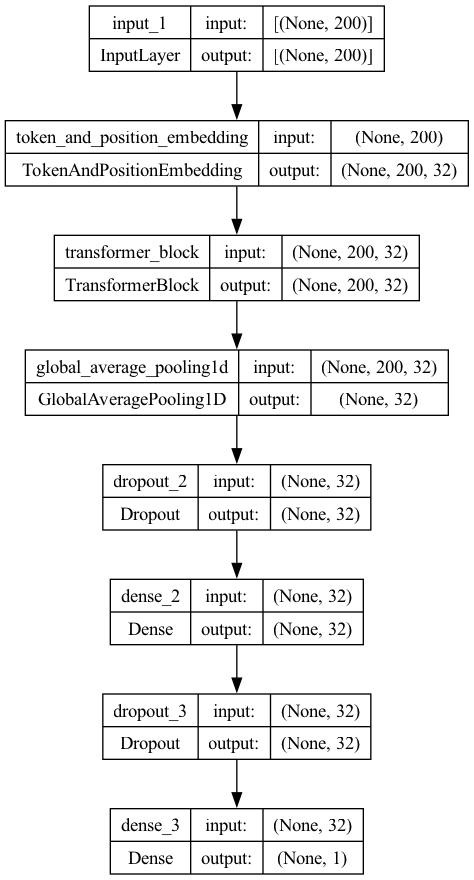

In [14]:
keras.utils.plot_model(model, show_shapes=True)

## Training

In [15]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
15/15 [==============================] - 2s 81ms/step - loss: 0.6983 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 1s 75ms/step - loss: 0.6799 - accuracy: 0.5622 - val_loss: 0.6654 - val_accuracy: 0.7050
Epoch 3/10
15/15 [==============================] - 1s 76ms/step - loss: 0.6194 - accuracy: 0.6644 - val_loss: 0.6136 - val_accuracy: 0.6800
Epoch 4/10
15/15 [==============================] - 1s 77ms/step - loss: 0.4663 - accuracy: 0.8517 - val_loss: 0.4977 - val_accuracy: 0.7650
Epoch 5/10
15/15 [==============================] - 1s 81ms/step - loss: 0.2413 - accuracy: 0.9367 - val_loss: 0.4942 - val_accuracy: 0.7550
Epoch 6/10
15/15 [==============================] - 1s 76ms/step - loss: 0.0936 - accuracy: 0.9733 - val_loss: 0.4933 - val_accuracy: 0.8150
Epoch 7/10
15/15 [==============================] - 1s 77ms/step - loss: 0.0208 - accuracy: 0.9978 - val_loss: 0.6298 - val_accuracy: 0.8100
Epoch 8/10
15

## Ploting Training Results

In [16]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

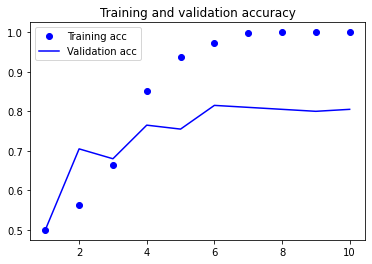

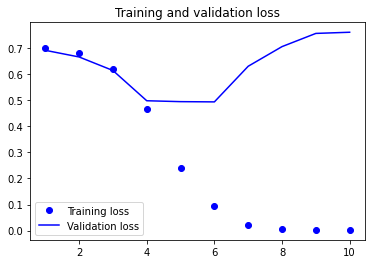

In [17]:
plot1(history)

- Given the small corpus size, it is clear to see that our model starts to overfit the training set quite a bit after the first few epochs (e.g, after the fourth epoch).
- In real application development, we may improve the model by:
    - increasing the datasets
    - increasing the embedding dimensions
    - using pre-trained embeddings
    - playing with the transformer blocks in terms of depths and widths of the layers
    - including dropouts, regularization, and normalization

## Explanation

In [18]:
explainer = LimeTextExplainer(class_names=["negative", "positive"])

In [19]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=maxlen)
    return np.array([[float(1 - x), float(x)]
                     for x in model.predict(np.array(_seq_pad))])
    #return model.predict(np.array(_seq_pad)) ## use this for logits

In [20]:
text_id = 123
model_predict_pipeline(x_val_text[[text_id]])

1/1 [==============================] - 0s 76ms/step


array([[1.39474869e-05, 9.99986053e-01]])

In [21]:
## correct label
y_val[text_id]

1

In [22]:
exp = explainer.explain_instance(x_val_text[text_id],
                                 model_predict_pipeline,
                                 num_features=10,
                                 top_labels=1)

exp.show_in_notebook(text=True)

157/157 [==============================] - 2s 11ms/step


## References

- This unit is based on the official keras tutorial: [Text classification with transfomer](https://keras.io/examples/nlp/text_classification_with_transformer/)
- Please read Peter Bloem's blog post on Transformers: [Transformers From Scratch](http://peterbloem.nl/blog/transformers). Highly recommended! Very comprehensive introduction of the attention mechanism and transformers.